* https://www.sciencedirect.com/science/article/pii/S2352340918315191
* https://www.kaggle.com/marcuswingen/eda-of-bookings-and-ml-to-predict-cancelations


<img src="https://ars.els-cdn.com/content/image/1-s2.0-S2352340918315191-gr1.jpg">

In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("data/feature.csv")
df.shape

(119390, 32)

In [3]:
df.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,...,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,...,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,...,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,...,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


In [4]:
nan_replacements = {"children:": 0.0,"country": "Unknown", "agent": 0, "company": 0}
full_data_cln = df.fillna(nan_replacements)

In [5]:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [6]:
num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["hotel","arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

In [7]:
features = num_features + cat_features
X = df.drop(["is_canceled"], axis=1)[features]
y = df["is_canceled"]

In [8]:
num_transformer = SimpleImputer(strategy="constant")

In [9]:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])

In [10]:
base_models = [("DT_model", DecisionTreeClassifier(random_state=42)),
               ("RF_model", RandomForestClassifier(random_state=42,n_jobs=-1)),
               ("LR_model", LogisticRegression(random_state=42,n_jobs=-1))]

* K-겹 교차검증
    * KFold: 일반적인 K-겹fold 교차검증 방법입니다.
    * StratifiedKFold: 각 클래스의 비율을 유지하면서 분할하는 방법입니다.

In [11]:
kfolds = 5
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

In [12]:
for name, model in base_models:
    model_steps = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', model)])
    
    cv_results = cross_val_score(model_steps, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)
    
    min_score = round(min(cv_results), 4)
    max_score = round(max(cv_results), 4)
    mean_score = round(np.mean(cv_results), 4)
    std_dev = round(np.std(cv_results), 4)
    print(f"{name} cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

DT_model cross validation accuarcy score: 0.8273 +/- 0.0017 (std) min: 0.8248, max: 0.8299
RF_model cross validation accuarcy score: 0.8676 +/- 0.0014 (std) min: 0.8655, max: 0.8688
LR_model cross validation accuarcy score: 0.7952 +/- 0.0016 (std) min: 0.7937, max: 0.7979


In [13]:
rf_model_enh = RandomForestClassifier(n_estimators=160,
                               max_features=0.4,
                               min_samples_split=2,
                               n_jobs=-1,
                               random_state=0)

split = KFold(n_splits=kfolds, shuffle=True, random_state=42)
model_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', rf_model_enh)])
cv_results = cross_val_score(model_pipe, 
                                 X, y, 
                                 cv=split,
                                 scoring="accuracy",
                                 n_jobs=-1)

min_score = round(min(cv_results), 4)
max_score = round(max(cv_results), 4)
mean_score = round(np.mean(cv_results), 4)
std_dev = round(np.std(cv_results), 4)
print(f"Enhanced RF model cross validation accuarcy score: {mean_score} +/- {std_dev} (std) min: {min_score}, max: {max_score}")

Enhanced RF model cross validation accuarcy score: 0.869 +/- 0.0017 (std) min: 0.8664, max: 0.8708


In [14]:
model_pipe.fit(X,y)

onehot_columns = list(model_pipe.named_steps['preprocessor'].
                      named_transformers_['cat'].
                      named_steps['onehot'].
                      get_feature_names(input_features=cat_features))

feat_imp_list = num_features + onehot_columns

In [15]:
# Feature importance evaluation
# !pip install eli5

In [16]:
import eli5
feat_imp_df = eli5.formatters.as_dataframe.explain_weights_df(
    model_pipe.named_steps['model'],
    feature_names=feat_imp_list)
feat_imp_df.head(10)

/Users/corazzon/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


,feature,weight,std
0,lead_time,0.145140,0.015235
1,deposit_type_Non Refund,0.140641,0.108007
2,adr,0.096222,0.003412
3,deposit_type_No Deposit,0.079059,0.106235
4,arrival_date_day_of_month,0.069410,0.002033
5,arrival_date_week_number,0.053763,0.001999
6,total_of_special_requests,0.050567,0.013314
7,agent,0.043060,0.006392
8,stays_in_week_nights,0.041588,0.002291
9,previous_cancellations,0.038626,0.013459


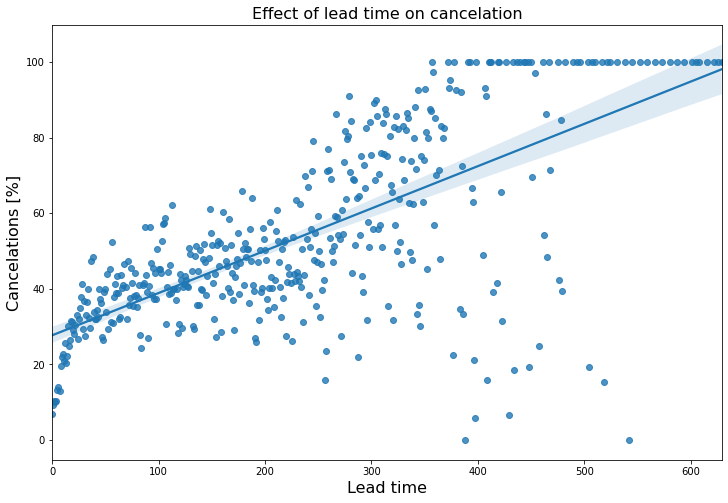

In [19]:
lead_cancel_data = full_data_cln.groupby("lead_time")["is_canceled"].describe()
lead_cancel_data_10 = lead_cancel_data.loc[lead_cancel_data["count"] >= 10]

plt.figure(figsize=(12, 8))
sns.regplot(x=lead_cancel_data_10.index, y=lead_cancel_data_10["mean"].values * 100)
plt.title("Effect of lead time on cancelation", fontsize=16)
plt.xlabel("Lead time", fontsize=16)
plt.ylabel("Cancelations [%]", fontsize=16)
# plt.xlim(0,365)
plt.show()

In [35]:
deposit_cancel_data = full_data_cln.groupby("deposit_type")["is_canceled"].describe()
deposit_cancel_data

,count,mean,std,min,25%,50%,75%,max
deposit_type,,,,,,,,
No Deposit,104641.0,0.283770,0.450829,0.0,0.0,0.0,1.0,1.0
Non Refund,14587.0,0.993624,0.079595,0.0,1.0,1.0,1.0,1.0
Refundable,162.0,0.222222,0.417029,0.0,0.0,0.0,0.0,1.0
